<a href="https://colab.research.google.com/github/Storce/PorfolioProjectionStone/blob/main/Dashboard_Proje%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Premissas Iniciais
import pandas as pd
from google.cloud import bigquery
from google.colab import auth

from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

import ipywidgets as widgets
from scipy.optimize import fsolve, minimize, differential_evolution

# Preferencia de pandas
pd.set_option('display.max_rows', 150)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None

#----------------- Definir classes e funcoes --------------------------
# Funcao conversao mensal -> taxa dia
def taxa_periodo(periodo, taxa_final):
  periodo += 1
  if periodo == 1 or taxa_final == 0:
    return 0
  relacao = np.log(21) / taxa_final
  logg1 = np.log(periodo - 1) / relacao
  loggg = np.log(periodo) / relacao
  final = loggg - logg1
  return final

# Funcao pmt
def f_pmt(principal, juros_diaria, dias_totais):
    pmt = (principal * juros_diaria * (1 + juros_diaria) ** dias_totais) / ((1 + juros_diaria) ** dias_totais - 1)
    return pmt

# Funcao por centagem PMT
def f_pmt_pc(juros_diaria, dias_totais):
    pmt = (juros_diaria * (1 + juros_diaria) ** dias_totais) / ((1 + juros_diaria) ** dias_totais - 1)
    return pmt

# Funcao juros dia
def f_juros_dia(juros_mensal):
  juros_dia = ((1 + juros_mensal) ** (1 / 30)) - 1
  return juros_dia

# ganho medio diario para bater a meta
def f_meta(valor_inicial, valor_meta, dias_ate_meta, taxa_pmt, taxa_juros):
  term1 = (valor_meta - (valor_inicial * ((1 + taxa_juros - taxa_pmt)**dias_ate_meta)))
  term2 = (1 - (1 + taxa_juros - taxa_pmt))
  term3 = (1 - ((1 + taxa_juros - taxa_pmt)**dias_ate_meta))

  meta_diaria = (term1 * term2) / term3
  return meta_diaria

# Desembolso diario necessario para bater a mata
def f_meta_diaria(valor_inicial, valor_meta, taxa_juros, taxa_pmt, dias_ate_meta):
    def equation(meta_diaria):
        valor_prev = valor_inicial
        for i in range(1, dias_ate_meta + 1):
            valor_atual = valor_prev * taxa_juros - taxa_pmt * (valor_inicial + (i - 1) * meta_diaria) + meta_diaria + valor_prev
            valor_prev = valor_atual
        return valor_atual - valor_meta

    meta_diaria_guess = 1  # Initial guess for meta_diaria
    meta_diaria_solution, = fsolve(equation, meta_diaria_guess)
    return meta_diaria_solution

# Grafico de barra de uma categoria
def grafico_barra1(change, dado, titulo, catogoria1, color1, data_final, figsize_x, figsize_y):

    startVal = pd.to_datetime(dia_referencia)
    endVal = pd.to_datetime(data_final)

    filtered_data = dado[(dado.index >= startVal) & (dado.index <= endVal)]
    # Plotting
    fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))

    # Set width of bar
    bar_width = 0.35

    # Set positions of bars on X axis
    r1 = range(len(filtered_data))

    # Create bar plots
    bars1 = ax.bar(r1, filtered_data[catogoria1], color=color1, width=bar_width, edgecolor='grey', label=catogoria1)

    # Adding labels and title
    ax.set_xlabel('Mês', fontweight='bold')
    ax.set_ylabel('R$', fontweight='bold')
    ax.set_title(titulo)
    ax.set_xticks([r + bar_width / 2 for r in range(len(filtered_data))])
    ax.set_xticklabels([date.strftime("%m / %Y") for date in filtered_data.index], rotation=45, ha='right')

    for bar in bars1:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, str(round(yval / 1e6)) + 'M', ha='center', va='bottom', fontsize=9)
    # Add a legend
    ax.legend()
    # Display the plot
    plt.show()

# Grafico de barra de duas categorias
def grafico_barra2(change, dado, titulo, catogoria1, categoria2, color1, color2, data_final, figsize_x, figsize_y):

    startVal = pd.to_datetime(dia_referencia)
    endVal = pd.to_datetime(data_final)

    filtered_data = dado[(dado.index >= startVal) & (dado.index <= endVal)]
    # Plotting
    fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))

    # Set width of bar
    bar_width = 0.35

    # Set positions of bars on X axis
    r1 = range(len(filtered_data))
    r2 = [x + bar_width for x in r1]

    # Create bar plots
    bars1 = ax.bar(r1, filtered_data[catogoria1], color=color1, width=bar_width, edgecolor='grey', label=catogoria1)
    bars2 = ax.bar(r2, filtered_data[categoria2], color=color2, width=bar_width, edgecolor='grey', label=categoria2)

    # Adding labels and title
    ax.set_xlabel('Mês', fontweight='bold')
    ax.set_ylabel('R$', fontweight='bold')
    ax.set_title(titulo)
    ax.set_xticks([r + bar_width / 2 for r in range(len(filtered_data))])
    ax.set_xticklabels([date.strftime("%m / %Y") for date in filtered_data.index], rotation=45, ha='right')

    for bar in bars1:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, str(round(yval / 1e6)) + 'M', ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, str(round(yval / 1e6)) + 'M', ha='center', va='bottom', fontsize=9)
    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()

# Grafico de barra de duas categorias
def grafico_barra3(change, dado, titulo, categoria1, categoria2, categoria3, color1, color2, color3, data_final, figsize_x, figsize_y):
    startVal = pd.to_datetime(dia_referencia)
    endVal = pd.to_datetime(data_final)

    filtered_data = dado[(dado.index >= startVal) & (dado.index <= endVal)]
    # Plotting
    fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))

    # Set width of bar
    bar_width = 0.25  # Adjust as needed for spacing between bars

    # Set positions of bars on X axis
    r1 = range(len(filtered_data))
    r2 = [x + bar_width for x in r1]
    r3 = [x + 2*bar_width for x in r1]

    # Create bar plots
    bars1 = ax.bar(r1, filtered_data[categoria1], color=color1, width=bar_width, edgecolor='grey', label=categoria1)
    bars2 = ax.bar(r2, filtered_data[categoria2], color=color2, width=bar_width, edgecolor='grey', label=categoria2)
    bars3 = ax.bar(r3, filtered_data[categoria3], color=color3, width=bar_width, edgecolor='grey', label=categoria3)

    # Adding labels and title
    ax.set_xlabel('Mês', fontweight='bold')
    ax.set_ylabel('R$', fontweight='bold')
    ax.set_title(titulo)
    ax.set_xticks([r + bar_width for r in range(len(filtered_data))])
    ax.set_xticklabels([date.strftime("%m / %Y") for date in filtered_data.index], rotation=45, ha='right')

    for bar in bars1:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, str(round(yval / 1e6)) + 'M', ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, str(round(yval / 1e6)) + 'M', ha='center', va='bottom', fontsize=9)
    for bar in bars3:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, str(round(yval / 1e6)) + 'M', ha='center', va='bottom', fontsize=9)

    # Add a legend
    ax.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

#---------------------------Datas e dias--------------------------------
# Obeter datas
dia_referencia = datetime.now() - timedelta(days=1)
dias_projecao = 365

#------------------------- Meta e Conversão ---------------------------------
class Meta:
  def __init__ (self, meta_aut, meta_es, dia_meta):
    self.meta_geral = meta_aut + meta_es
    self.meta_aut = meta_aut
    self.meta_es = meta_es
    self.dia_meta = dia_meta
    self.dias_ate_meta = (dia_meta - dia_referencia).days + 1

meta_list = [Meta(610_000_000, 100_000_000, datetime(2024, 6, 30)),
             Meta(733_422_227, 150_000_000, datetime(2024, 9, 30)),
             Meta(808_144_725, 250_000_000, datetime(2024, 12, 31))]

conversao_mensal = 2

#------------------------- print ---------------------------------
print("Estabelecando algumas premissas antes de começar.")
print('')
print('O dia de referência (D-1) é', dia_referencia.date(), '.')
print(f'Faremos a projeção da carteira pelos próximos {dias_projecao} dias.')
print(f'A taxa de conversão prevista pelo modelo é {conversao_mensal}%')
print('As nossas próximas metas são:')
temp = 1
for meta in meta_list:
  print(f"Meta {meta.dia_meta.date()} -", 'Valor:', f'{meta.meta_geral:,}', '/ Esteira Automática:', f'{meta.meta_aut:,}',
        '/ Esteira Especializada:', f'{meta.meta_es:,}', '/ Dias até meta:', meta.dias_ate_meta)

Estabelecando algumas premissas antes de começar.

O dia de referência (D-1) é 2024-06-27 .
Faremos a projeção da carteira pelos próximos 365 dias.
A taxa de conversão prevista pelo modelo é 2%
As nossas próximas metas são:
Meta 2024-06-30 - Valor: 710,000,000 / Esteira Automática: 610,000,000 / Esteira Especializada: 100,000,000 / Dias até meta: 3
Meta 2024-09-30 - Valor: 883,422,227 / Esteira Automática: 733,422,227 / Esteira Especializada: 150,000,000 / Dias até meta: 95
Meta 2024-12-31 - Valor: 1,058,144,725 / Esteira Automática: 808,144,725 / Esteira Especializada: 250,000,000 / Dias até meta: 187


In [ ]:
#@title Importando Dados
#--------------------------autenticacao--------------------------
# Autenticacao -> criar objeto de bigquery -> retrieve query -> transformar para dataframe
print("Autenticando Usuário...")

auth.authenticate_user()

print("Autenticação realizada com sucesso! Carregando Dados...")

client_bigquery = bigquery.Client(project = 'ski7v3oqx1y3pdcxxbtfsq4qm5j70j')

query_arranjos_credito = f"""
SELECT
  a.data_referencia,
  a.LoanId,
  a.saldo_gerencial_60,
  a.data_vencimento,
  a.valor_desembolsado,
  a.valor_financiado_total,
  a.data_desembolso,
  COALESCE(b.InterestRate, a.perc_juros_dia) AS juros_mensal,
  b.offerType
FROM
  `dataplatform-prd.credit_data_tribe.tbl_portfolio_carteira_gerencial_diaria_analitico` AS a
LEFT JOIN
  `dataplatform-prd.credit_business_intelligence.tbl_business_offer_tracker` AS b
  ON a.LoanId = b.LoanId
WHERE
  a.data_referencia = '{str(dia_referencia.date())}'
"""

query_desembolso_hj = f"""
SELECT
  A.Id,
  A.CreditAmountIOF,
  A.DueDate,
  B.InterestRate AS juros_mensal,
  B.LoanId,
  B.offerType
FROM
  `dataplatform-prd.credit_business_intelligence.vw_new_loan` as A
INNER JOIN
  `dataplatform-prd.credit_business_intelligence.tbl_business_offer_tracker` as B
ON
  A.Id = B.LoanId
WHERE
  DATE(A.DisbursementDateBRT) = '{str(dia_referencia.date() + timedelta(days=1))}'
"""

query_em_analise = """
SELECT
    a.OfferId,
    a.CreditAmount,
    a.Esteira,
    a.diaPrevistoDesembolso,
    b.InterestRate,
    b.maximumTerm
FROM
    `dataplatform-prd.credit_negocios.tbl_db_desembolso_tesouraria_clientes` AS a
LEFT JOIN
  `dataplatform-prd.credit_business_intelligence.tbl_business_offer_tracker` AS b
  ON a.OfferId = b.offerId
WHERE
    b.InterestRate IS NOT NULL
    AND b.maximumTerm IS NOT NULL
"""

query_ofertas = f"""
SELECT
  Status
FROM
  `dataplatform-prd.credit_business_intelligence.tbl_business_offer_tracker`
WHERE
  Status = 'Available'
"""

query_feriado = """
SELECT
  *
FROM
  `dataplatform-prd.credit_negocios.feriados_nacionais`
"""

# tabela geral
query_job = client_bigquery.query(query_arranjos_credito)
df = query_job.to_dataframe()
if len(df) == 0:
  dia_referencia -= timedelta(days=1)
  query_job = client_bigquery.query(query_arranjos_credito)
  df = query_job.to_dataframe()

# tabela desembolso
query_job = client_bigquery.query(query_desembolso_hj)
df_desembolso = query_job.to_dataframe()

# table analise
query_job = client_bigquery.query(query_em_analise)
df_analise = query_job.to_dataframe()

# Registrar feriados
query_job = client_bigquery.query(query_feriado)
df_feriado = query_job.to_dataframe()

feriados_set = set()
feriados = []
for feriado in df_feriado['full_date']:
  feriados_set.add(feriado)
  feriados.append(feriado)

# Obter numero de ofertas
query_job = client_bigquery.query(query_ofertas)
df_ofertas = query_job.to_dataframe()
ofertas_totais = len(df_ofertas)


#---------------------- explicação ------------------------------
print('')
print('A carteira atual é formada por três componentes:')
print('1, Tabela de tickets em amortização (no dia D-1)')
print('2, Tabela de tickets que foram desembolsados hoje')
print('3, Tabela de ticket em análise')

print('-------------------------------------------------------------------------')
print('Tickets em amortização (visualizando os três no topo):')
display(df.head(3))
print(f'Um total de {len(df)} tickets.')

print('-------------------------------------------------------------------------')
print('Tickets que foram desembolsados hoje (visualizando os três no topo):')
display(df_desembolso.head(3))
print(f'Um total de {len(df_desembolso)} tickets.')

print('-------------------------------------------------------------------------')
print('Tickets em análise (visualizando os três no topo):')
display(df_analise.head(3))
print(f'Um total de {len(df_analise)} tickets.')

print('')
print('Além das três tabelas, precisamos de duas tabelas de auxílio:')
print('1, Tabela com feriados nacionais, já que esses afetam a conversão e valor de pagamento diário.')
print('2, Tabela com todas as nossas ofertas, para poder estimar o valor de conversão na esteira automática.')

print('-------------------------------------------------------------------------')
print('Feriados (visualizando os três no topo):')
display(df_feriado.head(3))
max_date = df_feriado['full_date'].max()
print(f'Feriados até {max_date}')

print('-------------------------------------------------------------------------')
print('Ofertais totais (visualizando os três no topo):')
display(df_ofertas.head(3))
print('Numero de ofertas totais:', ofertas_totais)

Autenticando Usuário...
Autenticação realizada com sucesso! Carregando Dados...

A carteira atual é formada por três componentes:
1, Tabela de tickets em amortização (no dia D-1)
2, Tabela de tickets que foram desembolsados hoje
3, Tabela de ticket em análise
-------------------------------------------------------------------------
Tickets em amortização (visualizando os três no topo):


,data_referencia,LoanId,saldo_gerencial_60,data_vencimento,valor_desembolsado,valor_financiado_total,data_desembolso,juros_mensal,offerType
0,2024-06-27,jr288ubhdcbfb9rbffvvtn4sh,42936.526000000,2025-08-20,52902.000000000,53913.690399398,2024-02-09,0.024900000,Automatica
1,2024-06-27,jr2f6bxj9egd9vsuj5dgsegq5,12459.328000000,2025-08-27,15000.000000000,15286.857888000,2024-02-20,0.024900000,Automatica
2,2024-06-27,jr3pga6dmxf2f42kgbq99x6h1,35994.450000000,2025-10-17,40000.000000000,40764.954368000,2024-04-09,0.024900000,Automatica


Um total de 24086 tickets.
-------------------------------------------------------------------------
Tickets que foram desembolsados hoje (visualizando os três no topo):


,Id,CreditAmountIOF,DueDate,juros_mensal,LoanId,offerType
0,jr5qq254f9zbaac4x1q6hv1k6,"15,622.15",2026-01-05,0.030900000,jr5qq254f9zbaac4x1q6hv1k6,Automatica
1,jr5pfq8n2v1jdsjqes8x799z7,"65,932.22",2025-07-02,0.043900000,jr5pfq8n2v1jdsjqes8x799z7,Automatica
2,jr5qs5hmncq24eh3dwdvrdjsy,"29,764.53",2025-07-03,0.049900000,jr5qs5hmncq24eh3dwdvrdjsy,Automatica


Um total de 128 tickets.
-------------------------------------------------------------------------
Tickets em análise (visualizando os três no topo):


,OfferId,CreditAmount,Esteira,diaPrevistoDesembolso,InterestRate,maximumTerm
0,jr5asvzan3hkgkh5jdjb7d2ux,"5,000.00",Automatica,2024-07-02,0.049900000,12
1,jr5ap9zjdh6qdwd3hnxbn1ctt,"7,507.00",Automatica,2024-07-01,0.025900000,18
2,jr5jdt9yn1wa1z9r4yqyk12d5,"37,511.00",Automatica,2024-07-01,0.042500000,18


Um total de 63 tickets.

Além das três tabelas, precisamos de duas tabelas de auxílio:
1, Tabela com feriados nacionais, já que esses afetam a conversão e valor de pagamento diário.
2, Tabela com todas as nossas ofertas, para poder estimar o valor de conversão na esteira automática.
-------------------------------------------------------------------------
Feriados (visualizando os três no topo):


,full_date
0,2027-03-26
1,2027-02-09
2,2027-05-01


Feriados até 2029-12-25
-------------------------------------------------------------------------
Ofertais totais (visualizando os três no topo):


,Status
0,Available
1,Available
2,Available


Numero de ofertas totais: 83570


In [ ]:
#@title Análise Individual de Tickets
# ---------------- Mudando tipo de objeto para facilitar processamento ------------------------
df['data_vencimento'] = pd.to_datetime(df['data_vencimento'])
df_desembolso['DueDate'] = pd.to_datetime(df_desembolso['DueDate'])


# -------------------------- Tabela D-1 -----------------------
# Dias Vencimento
def f_dia_vencimento(dia_vencimento):
    return (dia_vencimento - dia_referencia).days

df['dias_ate_vencimento'] = df['data_vencimento'].apply(f_dia_vencimento)

# Amortizacao, juros, pagamento_diario
df['juros_diaria'] = np.where(df['dias_ate_vencimento'] < 0, 0, f_juros_dia(df['juros_mensal'].astype(float)))
df['pagamento_diario'] = np.select([df['dias_ate_vencimento'] == 0, df['dias_ate_vencimento'] < 0],
                                  [df['saldo_gerencial_60'], 0],
                                  default=f_pmt(df['saldo_gerencial_60'].astype(float), df['juros_diaria'], df['dias_ate_vencimento']))
# Essa liquida eh a amortizacao do primeiro dia
df['amortizacao_diaria_liqui'] = df['pagamento_diario'].astype(float) - (df['juros_diaria'] * df['saldo_gerencial_60'].astype(float))
# Saldo após amortizacao do primeiro dia
df['saldo_gerencial_60_dia0'] = df['saldo_gerencial_60'].astype(float) - df['amortizacao_diaria_liqui']


# -------------------------- Tabela Desembolso -----------------------
# Dias Vencimento
if len(df_desembolso) > 0:
  df_desembolso['dias_ate_vencimento'] = df_desembolso['DueDate'].apply(f_dia_vencimento)

# Amortizacao, juros, pagamento_diario
  df_desembolso['juros_diaria'] = f_juros_dia(df_desembolso['juros_mensal'].astype(float))
  df_desembolso['pagamento_diario'] = f_pmt(df_desembolso['CreditAmountIOF'].astype(float), df_desembolso['juros_diaria'], df_desembolso['dias_ate_vencimento'])
  df_desembolso['amortizacao_diaria_liqui'] = df_desembolso['pagamento_diario'] - (df_desembolso['juros_diaria'] * df_desembolso['CreditAmountIOF'].astype(float))


# -------------------------- Tabela Análise -----------------------
def f_dia_ate_desembolso(dia_previsto_desembolso):
  if dia_previsto_desembolso < dia_referencia.date():
    return 0
  else:
    return (dia_previsto_desembolso - dia_referencia.date()).days + 1

if len(df_analise) > 0:
  df_analise['dias_ate_vencimento'] = (df_analise['maximumTerm'] * 30.4).astype(int)

# Amortizacao, juros, pagamento_diario
  df_analise['juros_diaria'] = f_juros_dia(df_analise['InterestRate'].astype(float))
  df_analise['pagamento_diario'] = f_pmt(df_analise['CreditAmount'].astype(float), df_analise['juros_diaria'], df_analise['dias_ate_vencimento'])
  df_analise['amortizacao_diaria_liqui'] = df_analise['pagamento_diario'] - (df_analise['juros_diaria'] * df_analise['CreditAmount'].astype(float))
  df_analise['dias_ate_desembolso'] = df_analise['diaPrevistoDesembolso'].apply(f_dia_ate_desembolso)


# ---------------- Separando automatica da especializada --------------
df_es = df[df['offerType'] == 'Especializada']
df_desembolso_es = df_desembolso[df_desembolso['offerType'] == 'Especializada']
df_analise_es = df_analise[df_analise['Esteira'] == 'Especializada']

df_aut = df[(df['offerType'] == 'Automatica') | (pd.isnull(df['offerType']))]
df_desembolso_aut = df_desembolso[df_desembolso['offerType'] == 'Automatica']
df_analise_aut = df_analise[(df_analise['Esteira'] == 'Automatica') | (pd.isnull(df_analise['Esteira']))]


# -------------------------- Ticket Teste --------------------------------
Id_teste = 'jr1k5r688eq315kvznfz6ev8a'
pagamento_diario_teste = df.loc[df['LoanId'] == Id_teste, 'pagamento_diario']
juros_teste = df.loc[df['LoanId'] == Id_teste, 'juros_diaria']
saldo_devedor_teste = df.loc[df['LoanId'] == Id_teste, 'saldo_gerencial_60']
dia_vencimento_teste = df.loc[df['LoanId'] == Id_teste, 'data_vencimento']
amortizacao_liqui_teste = df.loc[df['LoanId'] == Id_teste, 'amortizacao_diaria_liqui']


# -------------------------- Explicação ----------------------------------------
print('Primeira parte da projeção é estimar a amortização da carteira atual. Para isso, partimos de análise ticket-por-ticket.')
print('1. Juros diário (já que a projeção é feita a base diária), estimado baseado no juros mensal.')
print('2. Pagamento diário ou valor retido diário, baseado no saldo devedor, juros diário e no número de dias até o vencimento.')
print('Com esses dois valores, podemos estimar a amortização líquida diária, que vai ser fundamental para a projeção da amortização da carteira atual.')

print('')
print('Tirando um ticket como amostra, temos:')
print(f'ID de teste: {Id_teste}')
print(f'Saldo devedor: R${round(saldo_devedor_teste.values[0], 2)}')
print(f'Dia de vencimento: {pd.to_datetime(dia_vencimento_teste.values[0]).date()}')
print(f'Juros diário: {round(juros_teste.values[0] * 100, 3)}%')
print(f'Pagamento diário: R$ {round(pagamento_diario_teste.values[0], 2)}')
print(f'Amortização liquida no primeiro dia: R$ {round(amortizacao_liqui_teste.values[0], 2)}')

print('')
print('Após isso, separamos os tickets por esteiras, preparando para próximos passos.')
print('')
print('*Fazemos esse processo para todos os tickets: os desembolsados hoje, os já em amortização, e os ainda em análise.')

# df_t = df[(df['dias_ate_vencimento'] < 178) & (df['offerType'] == 'Especializada')]
# display(df_t.head(100))
# df_t = df[(df['dias_ate_vencimento'] > 1399) & (df['offerType'] == 'Especializada')]
# display(df_t.head(100))
# print(df_es['dias_ate_vencimento'].min())

print(df_aut['saldo_gerencial_60_dia0'].sum())
print(df_desembolso_aut['CreditAmountIOF'].sum())
print(float(df_aut['saldo_gerencial_60'].sum()) + df_desembolso_aut['CreditAmountIOF'].sum())

Primeira parte da projeção é estimar a amortização da carteira atual. Para isso, partimos de análise ticket-por-ticket.
1. Juros diário (já que a projeção é feita a base diária), estimado baseado no juros mensal.
2. Pagamento diário ou valor retido diário, baseado no saldo devedor, juros diário e no número de dias até o vencimento.
Com esses dois valores, podemos estimar a amortização líquida diária, que vai ser fundamental para a projeção da amortização da carteira atual.

Tirando um ticket como amostra, temos:
ID de teste: jr1k5r688eq315kvznfz6ev8a
Saldo devedor: R$31154.29
Dia de vencimento: 2025-07-21
Juros diário: 0.066%
Pagamento diário: R$ 90.99
Amortização liquida no primeiro dia: R$ 70.52

Após isso, separamos os tickets por esteiras, preparando para próximos passos.

*Fazemos esse processo para todos os tickets: os desembolsados hoje, os já em amortização, e os ainda em análise.
608043631.038099
3836580.8377555236
613590860.8897556


Finalmente vamos iniciar a projeção. Começamos pela esteira especializada.
Usamos os juros diários e os pagamentos diários médios que achamos no paso anterior, podemos projetar a amortização de cade ticket individualmente.
Logo depois, somamos a projeção de cada ticket atual baseado nos dias de desembolso e vencimento, resultando, assim, na amortização projetada da carteira atual.
Além disso, consideramos que não recebemos pagamentos nos finais de semana nem nos feriados (representados por '8' na coluna dia_da_semana), e que a amortização nesses dias caem somente no primeiro dia útil em seguida.
Finalmente, também consideramos que os contratos em atraso não amortizem, ou seja, mantenham-se constante ao longo do tempo.

Obetemos a seguinte tabela:


,data_referencia,dia_da_semana,pagamento_diario,juros_diario,amort_liqui,carteira_realizada
0,2024-06-28,5,"133,301.35","57,287.52","76,013.84","68,736,378.36"
1,2024-06-29,6,0.00,"57,222.66","-57,222.66","68,793,601.02"
2,2024-06-30,7,0.00,"57,157.74","-57,157.74","68,850,758.75"
3,2024-07-01,1,"399,904.06","57,092.75","342,811.31","68,507,947.45"
4,2024-07-02,2,"133,301.35","57,027.71","76,273.65","68,431,673.80"
...,...,...,...,...,...,...
1385,2028-04-13,4,"1,543.43",7.83,"1,535.59","4,618.52"
1386,2028-04-14,8,0.00,5.88,-5.88,"4,624.40"
1387,2028-04-15,6,0.00,3.92,-3.92,"4,628.32"
1388,2028-04-16,7,0.00,1.96,-1.96,"4,630.28"


Observamos que a carteira de hoje está em 68,736,378.36, e a carteira vai terminar de amortizar no 2028-04-18 
Representando essa projeção em gráfico, temos:


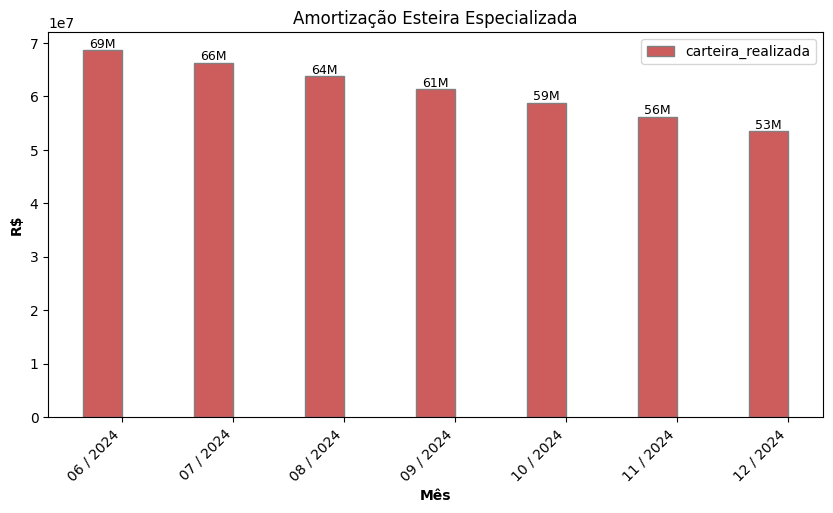

No final da meta de 2024-06-30, de R$ 100,000,000 a carteira estará em  R$ 68,584,156.05 reais
No final da meta de 2024-09-30, de R$ 150,000,000 a carteira estará em  R$ 61,292,443.38 reais
No final da meta de 2024-12-31, de R$ 250,000,000 a carteira estará em  R$ 53,415,674.11 reais


In [ ]:
#@title Projeção Esteira Especializada, Paso I: Amoritzação dos tickets em amortização, desembolsados hoje e em análise
max_date_range = (max(df_es['data_vencimento'].max(), df_desembolso_es['DueDate'].max()) - dia_referencia).days + 2
df_es_proj = pd.DataFrame(pd.date_range(start=datetime.now().date(), end=(datetime.now() + timedelta(days=max_date_range)).date()), columns=['data_referencia'])

df_es_proj['pagamento_diario'] = 0
df_es_proj['juros_diario'] = 0
df_es_proj['amort_liqui'] = 0
df_es_proj['carteira_realizada'] = 0
df_es_proj['dia_da_semana'] = ''


pagamento_diario_cum = np.zeros(len(df_es_proj))
juros_diario_cum = np.zeros(len(df_es_proj))
carteira_realizada_cum = np.zeros(len(df_es_proj))

# Adicionar Tickets de D-1
for _, row in df_es.iterrows():
  pmt = float(row['pagamento_diario'])
  juros = row['juros_diaria']
  dias_ate_vencimento = row['dias_ate_vencimento']
  saldo_devedor_ori = float(row['saldo_gerencial_60_dia0'])

  # Lidando com tickets atrasados
  if dias_ate_vencimento < 0:
    mask = df_es_proj.index > -1
    indices = df_es_proj.index[mask]
    juros_calc = 0
    carteira_realizada_calc = saldo_devedor_ori

  else:
    mask = df_es_proj.index <= dias_ate_vencimento - 1
    indices = df_es_proj.index[mask]
    juros_calc = juros * (saldo_devedor_ori * (1 + juros)**(indices - 1) -
                          (pmt / juros) * ((1 + juros)**(indices - 1) - 1))
    carteira_realizada_calc = saldo_devedor_ori * (1 + juros)**indices - (pmt / juros) * ((1 + juros)**indices - 1)

  pagamento_diario_cum[mask] += pmt
  juros_diario_cum[mask] += juros_calc
  carteira_realizada_cum[mask] += carteira_realizada_calc

# Adicionar Tickets desembolsados
for _, row in df_desembolso_es.iterrows():
  pmt = float(row['pagamento_diario'])
  juros = row['juros_diaria']
  dias_ate_vencimento = row['dias_ate_vencimento']
  saldo_devedor_ori = float(row['CreditAmountIOF'])

  mask = df_es_proj.index <= dias_ate_vencimento
  indices = df_es_proj.index[mask]

  pagamento_diario_cum[mask] += pmt

  juros_calc = juros * (saldo_devedor_ori * (1 + juros)**(indices - 1) -
                        (pmt / juros) * ((1 + juros)**(indices - 1) - 1))
  juros_diario_cum[mask] += juros_calc

  carteira_realizada_calc = saldo_devedor_ori * (1 + juros)**indices - (pmt / juros) * ((1 + juros)**indices - 1)
  carteira_realizada_cum[mask] += carteira_realizada_calc



# Adicionar Tickets em análise
for _, row in df_analise_es.iterrows():
  pmt = float(row['pagamento_diario'])
  juros = row['juros_diaria']
  dias_ate_vencimento = row['dias_ate_vencimento']
  dias_ate_desembolso = row['dias_ate_desembolso']
  saldo_devedor_ori = float(row['CreditAmount'])

  mask = (df_es_proj.index <= dias_ate_vencimento) & (df_es_proj.index >= dias_ate_desembolso)
  indices = df_es_proj.index[mask]

  pagamento_diario_cum[mask] += pmt

  juros_calc = juros * (saldo_devedor_ori * (1 + juros)**(indices - 1) -
                        (pmt / juros) * ((1 + juros)**(indices - 1) - 1))
  juros_diario_cum[mask] += juros_calc

  carteira_realizada_calc = saldo_devedor_ori * (1 + juros)**indices - (pmt / juros) * ((1 + juros)**indices - 1)
  carteira_realizada_cum[mask] += carteira_realizada_calc


df_es_proj['pagamento_diario'] = pagamento_diario_cum
df_es_proj['juros_diario'] = juros_diario_cum
df_es_proj['amort_liqui'] = df_es_proj['pagamento_diario'] - df_es_proj['juros_diario']
df_es_proj['carteira_realizada'] = carteira_realizada_cum

df_es_proj_final = df_es_proj.copy()
df_es_proj_final['dia_da_semana'] = ''
df_es_proj_final = df_es_proj_final[['data_referencia', 'dia_da_semana', 'pagamento_diario', 'juros_diario', 'amort_liqui', 'carteira_realizada']]
pmt_cum = 0

# Mecanismos de finais de semana
for index, row in df_es_proj_final.iterrows():
  date = row['data_referencia']
  row['dia_da_semana'] = date.weekday() + 1
  if date.weekday() > 4 or date.date() in feriados:
    if date.date() in feriados:
      row['dia_da_semana'] = 8
    pmt_cum += row['pagamento_diario']
    row['carteira_realizada'] += pmt_cum
    row['pagamento_diario'] = 0
  else:
    row['pagamento_diario'] += pmt_cum
    pmt_cum = 0

  df_es_proj_final.iloc[index] = row

df_es_proj_final['amort_liqui'] = df_es_proj_final['pagamento_diario'] - df_es_proj_final['juros_diario']

# Obter valores importantes
carteira_atual_es = df_es_proj.loc[0, 'carteira_realizada']
dia_final = dia_referencia + timedelta(days=max_date_range)


# ------------------------ Divisao em meses ----------------------------
df_es_proj_mes = df_es_proj.copy()
df_es_proj_mes.set_index('data_referencia', inplace=True)
df_es_mes = df_es_proj_mes.resample('M').last()


# ----------------------- Explicação -----------------------
print('Finalmente vamos iniciar a projeção. Começamos pela esteira especializada.')
print('Usamos os juros diários e os pagamentos diários médios que achamos no paso anterior, podemos projetar a amortização de cade ticket individualmente.')
print('Logo depois, somamos a projeção de cada ticket atual baseado nos dias de desembolso e vencimento, resultando, assim, na amortização projetada da carteira atual.')
print("Além disso, consideramos que não recebemos pagamentos nos finais de semana nem nos feriados (representados por '8' na coluna dia_da_semana), e que a amortização nesses dias caem somente no primeiro dia útil em seguida.")
print('Finalmente, também consideramos que os contratos em atraso não amortizem, ou seja, mantenham-se constante ao longo do tempo.')

print('')
print('Obetemos a seguinte tabela:')
display(df_es_proj_final.head(max_date_range - 1))
print(f'Observamos que a carteira de hoje está em {carteira_atual_es:,.2f}, e a carteira vai terminar de amortizar no {dia_final.date()} ')
print('Representando essa projeção em gráfico, temos:')

grafico_barra1(1, df_es_mes, 'Amortização Esteira Especializada', 'carteira_realizada', 'indianred', meta_list[-1].dia_meta , 10, 5)

for meta in meta_list:
  valor_amortizado = df_es_proj.loc[df_es_proj['data_referencia'] == meta.dia_meta, 'carteira_realizada'].values[0]
  print(f'No final da meta de {meta.dia_meta.date()}, de R$ {meta.meta_es:,}', 'a carteira estará em ', f'R$ {round(valor_amortizado, 2):,}', 'reais')
# display(df_es_proj.head(180))
# print(df_es_proj.iloc[0, 4])

Com a carteira realizada projetada, podemos simular a carteira para descobrir a produção diária necessária para bater a meta de cada período.
Nessas simulações, definimos o prazo e o juros dos contratos novos baseados na média dos passados.
Também, aplicamos as mesmas premissas usadas na projeção da carteira realizada, como a natureza de amortização nos finais de semana e os mecanismos a amortização.

Simulando produções...
data_referencia              2024-09-30 00:00:00
dia_da_semana                                  1
amort_liqui                           349,001.34
carteira_realizada                 61,292,443.38
producao_diaria_necc                1,905,579.08
desembolso_diario_necc                956,704.41
pagamento_diario_producao             523,771.13
juros_diario_producao                  84,429.68
amort_liqui_producao                  439,341.45
carteira_producao                 150,000,000.00
Name: 94, dtype: object
data_referencia              2024-12-31 00:00:00
dia_da_se

,data_referencia,dia_da_semana,amort_liqui,carteira_realizada,producao_diaria_necc,desembolso_diario_necc,pagamento_diario_producao,juros_diario_producao,amort_liqui_producao,carteira_producao
0,2024-06-28,5,"76,013.84","68,736,378.36",0.00,"31,089,504.19",0.00,0.00,0.00,"99,825,882.54"
1,2024-06-29,6,"-57,222.66","68,793,601.02","956,704.41",0.00,0.00,"29,882.13","-29,882.13","99,912,987.34"
2,2024-06-30,7,"-57,157.74","68,850,758.75","956,704.41",0.00,0.00,"29,854.92","-29,854.92","100,000,000.00"
3,2024-07-01,1,"342,811.31","68,507,947.45","956,704.41","956,704.41","174,577.69","29,827.69","144,750.00","100,469,143.10"
4,2024-07-02,2,"76,273.65","68,431,673.80","956,704.41","956,704.41","59,983.30","30,719.97","29,263.33","101,320,310.54"
5,2024-07-03,3,"76,338.76","68,355,335.04","956,704.41","956,704.41","61,774.03","31,611.40","30,162.64","102,170,513.55"
6,2024-07-04,4,"76,403.94","68,278,931.11",0.00,"956,704.41","63,564.77","32,501.96","31,062.81","103,019,751.21"
7,2024-07-05,5,"76,469.18","68,202,461.93",0.00,"956,704.41","65,355.51","33,391.65","31,963.86","103,868,022.59"
8,2024-07-06,6,"-56,766.87","68,259,228.80","956,704.41",0.00,0.00,"34,280.48","-34,280.48","103,959,069.94"
9,2024-07-07,7,"-56,701.50","68,315,930.31","956,704.41",0.00,0.00,"34,248.89","-34,248.89","104,050,020.34"


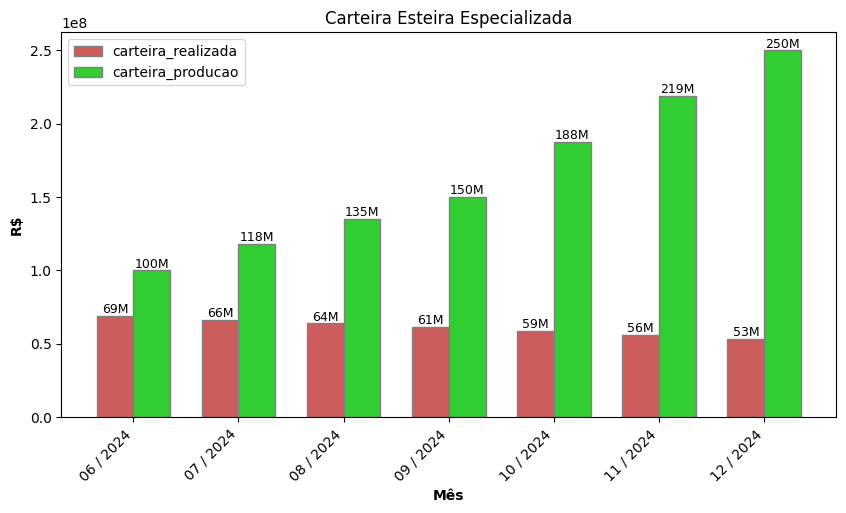

In [ ]:
#@title Projeção Esteira Especializada, Paso II: Cálculo da produção necessária para meta
# ------------------------ Explicação I ----------------------------------
print('Com a carteira realizada projetada, podemos simular a carteira para descobrir a produção diária necessária para bater a meta de cada período.')
print('Nessas simulações, definimos o prazo e o juros dos contratos novos baseados na média dos passados.')
print('Também, aplicamos as mesmas premissas usadas na projeção da carteira realizada, como a natureza de amortização nos finais de semana e os mecanismos a amortização.')
print('')

# Calcular medias baseadas somente nos tickets desembolsados no mês passado
juros_medio = df_es.loc[df_es['data_desembolso'] > (dia_referencia - timedelta(days=31))]['juros_diaria'].mean()
prazo_medio = int(df_es.loc[df_es['data_desembolso'] > (dia_referencia - timedelta(days=31))]['dias_ate_vencimento'].mean())

prct_pmt_medio = f_pmt_pc(juros_medio, prazo_medio)

# Limitar a df da projecao com meta até só a última meta
df_es_proj_meta = df_es_proj_final.loc[df_es_proj['data_referencia'] <= (meta_list[-1].dia_meta)]

# Iniciar alguns valores
df_es_proj_meta['producao_diaria_necc'] = 0
df_es_proj_meta["desembolso_diario_necc"] = 0
df_es_proj_meta['pagamento_diario_producao'] = 0
df_es_proj_meta['juros_diario_producao'] = 0
df_es_proj_meta['amort_liqui_producao'] = 0
df_es_proj_meta['carteira_producao'] = 0

pagamento_meta_cum = np.zeros(len(df_es_proj_meta))
juros_meta_cum = np.zeros(len(df_es_proj_meta))
carteira_meta_cum = df_es_proj_meta['carteira_realizada'].copy()

# ------------------------ Funcao Meta ---------------------------------
dia = 0
# List para guardar producao diaria necessaria para bater a meta
producao_list_es = []

print('Simulando produções...')

for meta in meta_list:
    gap = meta.meta_es - carteira_meta_cum.loc[meta.dias_ate_meta - 1]
    # Funcao de simulacao para achar producao diaria
    def f_simulacao(meta_diaria):
      carteira_meta_cum_teste = np.zeros(len(df_es_proj_meta))
      pagamento_meta_cum_teste = np.zeros(len(df_es_proj_meta))
      dia_teste = dia
      while dia_teste <= meta.dias_ate_meta - 1:
        pagamento = f_pmt(meta_diaria, juros_medio, prazo_medio)
        if df_es_proj_meta.loc[dia_teste, 'dia_da_semana'] <= 5:
          mask = (df_es_proj_meta.index >= dia) & (df_es_proj_meta.index <= prazo_medio)
          # A segunda mask existe para dislocar a coluna de pagamento e juros um dia para baixo.
          mask_pmt = (df_es_proj_meta.index >= dia + 1) & (df_es_proj_meta.index <= prazo_medio + 1)
          indices = df_es_proj_meta.index[mask] - dia_teste
          indices_pmt = df_es_proj_meta.index[mask_pmt] - dia

          pagamento_meta_cum_teste[mask_pmt] += pagamento
          carteira_realizada_calc = meta_diaria * (1 + juros_medio)**indices - (pagamento / juros_medio) * ((1 + juros_medio)**indices - 1)
          carteira_meta_cum_teste[mask] += carteira_realizada_calc
          dia_teste += 1
        else:
          dia_teste += 1

      # Loop para finais de semana e feriados
      pmt_cum = 0
      for index in range(len(df_es_proj_meta)):
        if df_es_proj_meta.loc[index, 'dia_da_semana'] > 5:
          pmt_cum += pagamento_meta_cum_teste[index]
          carteira_meta_cum_teste[index] += pmt_cum
          pagamento_meta_cum_teste[index] = 0
        else:
          pagamento_meta_cum_teste[index] += pmt_cum
          pmt_cum = 0

      return carteira_meta_cum_teste[meta.dias_ate_meta - 1]

    # Funcao para ser colocada no solver
    def f_minimize(meta_diaria):
      return abs(f_simulacao(meta_diaria) - gap)

    # Metodo LBFGSB para funcao nao diferenciavel
    if gap < 0 :
      optimal_meta_diaria = 0
    else:
      chute_inicial = (meta.meta_es - gap) / (meta.dias_ate_meta * 0.71)
      result = minimize(f_minimize, x0=chute_inicial, method='L-BFGS-B')
      optimal_meta_diaria = result.x[0]

    # Guardar producoes para display depois
    producao_list_es.append([optimal_meta_diaria, meta.dia_meta.date()])

    # Modificar a tabela principal baseada na producao simulada anteriormente (basicamente mesma estrucutra que a simulação anterior)
    while dia <= meta.dias_ate_meta - 1:
        pagamento = f_pmt(optimal_meta_diaria, juros_medio, prazo_medio)
        if df_es_proj_meta.loc[dia, 'dia_da_semana'] <= 5:
          # Producao
          if dia - 2 >= 0:
            df_es_proj_meta.loc[dia - 2, 'producao_diaria_necc'] = optimal_meta_diaria
          # Desembolso, delay de dois dias
          df_es_proj_meta.loc[dia, 'desembolso_diario_necc'] = optimal_meta_diaria
          mask = (df_es_proj_meta.index >= dia) & (df_es_proj_meta.index <= prazo_medio)
          mask_pmt = (df_es_proj_meta.index >= dia + 1) & (df_es_proj_meta.index <= prazo_medio + 1)
          indices = df_es_proj_meta.index[mask] - dia
          indices_pmt = df_es_proj_meta.index[mask_pmt] - dia

          pagamento_meta_cum[mask_pmt] += pagamento

          juros_calc = juros_medio * (optimal_meta_diaria * (1 + juros_medio)**(indices_pmt - 1) -
                          (pagamento / juros_medio) * ((1 + juros_medio)**(indices_pmt - 1) - 1))
          juros_meta_cum[mask_pmt] += juros_calc

          carteira_realizada_calc = optimal_meta_diaria * (1 + juros_medio)**indices - (pagamento / juros_medio) * ((1 + juros_medio)**indices - 1)
          carteira_meta_cum[mask] += carteira_realizada_calc
          dia += 1
        else:
          dia += 1

    # Implementando o mecanismo de amortizacao dos finais de semana
    pmt_cum = 0
    for index in range(len(df_es_proj_meta)):
      if df_es_proj_meta.loc[index, 'dia_da_semana'] > 5:
        pmt_cum += pagamento_meta_cum[index]
        carteira_meta_cum[index] += pmt_cum
        pagamento_meta_cum[index] = 0
      else:
        pagamento_meta_cum[index] += pmt_cum
        pmt_cum = 0

    # Implementando o mecanismo de amort


df_es_proj_meta['pagamento_diario_producao'] = pagamento_meta_cum
df_es_proj_meta['juros_diario_producao'] = juros_meta_cum
df_es_proj_meta['amort_liqui_producao'] = pagamento_meta_cum - juros_meta_cum
df_es_proj_meta['carteira_producao'] = carteira_meta_cum

# Tirar columns redundantes
df_es_proj_meta.drop(columns=['pagamento_diario', 'juros_diario'], inplace=True)
# ----------------------- Transformar em meses ---------------""
df_es_proj_meta_mes = df_es_proj_meta.copy()
df_es_proj_meta_mes.set_index('data_referencia', inplace=True)
df_es_proj_meta_mes = df_es_proj_meta_mes.resample('M').last()

# ------------------------ Explicação II ----------------------------------
print(df_es_proj_meta.loc[meta_list[1].dias_ate_meta - 1])
print(df_es_proj_meta.loc[meta_list[2].dias_ate_meta - 1])

print('')
print('Usando métodos de otimização, descobrimos que:')
for producao in producao_list_es:
  print(f'A produção diária necessária para bater a meta de {producao[1]} é {producao[0]:,.2f}')

print('')
print('A tabela simulada:')
display(df_es_proj_meta.head(20))

grafico_barra2(1, df_es_proj_meta_mes, 'Carteira Esteira Especializada', 'carteira_realizada', 'carteira_producao', 'indianred', 'limegreen', dia_final.date(), 10, 5)

In [ ]:
display(df_es_proj_meta.head(20))

Agora vamos começar a projeção da esteira automática, começando pela amortização e usando a mesma metodologia da especializada.
Já que a automática tem 23881 tickets, ou seja, 11549.0 % a mais que a especializada com 205 tickets, o processamento vai demorar mais.

25% processado...
50% processado...
75% processado...
100% processado!

Obetemos a seguinte tabela:


,data_referencia,dia_da_semana,pagamento_diario,juros_diario,amort_liqui,carteira_realizada
0,2024-06-28,5,"2,318,726.49","602,218.29","1,716,508.20","611,880,211.81"
1,2024-06-29,6,0.00,"600,450.46","-600,450.46","612,585,662.26"
2,2024-06-30,7,0.00,"598,826.78","-598,826.78","613,411,129.70"
3,2024-07-01,1,"6,957,365.71","596,965.91","6,360,399.80","607,050,729.90"
4,2024-07-02,2,"2,318,889.26","595,103.56","1,723,785.70","605,326,944.20"
...,...,...,...,...,...,...
1452,2028-06-19,1,"1,238.09",0.53,"1,237.56","571,900.18"
1453,2028-06-20,2,134.81,0.11,134.70,"571,765.48"
1454,2028-06-21,3,0.00,0.00,0.00,"571,765.48"
1455,2028-06-22,4,0.00,0.00,0.00,"571,765.48"


Observamos que a carteira de hoje está em 68,736,378.36, e a carteira vai terminar de amortizar no 2028-06-22 
Representando essa projeção em gráfico, temos:


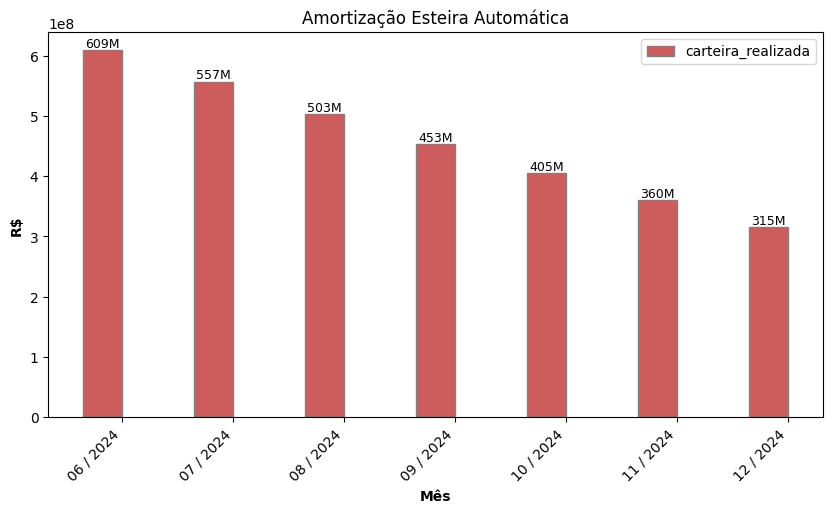


É interessante perceber, por exemplo, que o prazo médio de tickets da automática é muito menor e que a carteira nunca zera, devido a prevalência de tickets em atraso nessa esteira.


In [ ]:
#@title Projeção Esteira Automática, Paso I: Amoritzação dos tickets em amortização, desembolsados hoje e em análise
# Explicacao
print('Agora vamos começar a projeção da esteira automática, começando pela amortização e usando a mesma metodologia da especializada.')
print(f'Já que a automática tem {len(df_aut)} tickets, ou seja, {round(((len(df_aut) / len(df_es)) - 1) * 100, 0)} % a mais que a especializada com {len(df_es)} tickets, o processamento vai demorar mais.')
print('')

max_date_range = (max(df_aut['data_vencimento'].max(), df_desembolso_es['DueDate'].max()) - dia_referencia).days + 2
df_aut_proj = pd.DataFrame(pd.date_range(start=datetime.now().date(), end=(datetime.now() + timedelta(days=max_date_range)).date()), columns=['data_referencia'])

df_aut_proj['pagamento_diario'] = 0
df_aut_proj['juros_diario'] = 0
df_aut_proj['amort_liqui'] = 0
df_aut_proj['carteira_realizada'] = 0
df_aut_proj['dia_da_semana'] = ''

numero_total_ticket = len(df_aut)

pagamento_diario_cum = np.zeros(len(df_aut_proj))
juros_diario_cum = np.zeros(len(df_aut_proj))
carteira_realizada_cum = np.zeros(len(df_aut_proj))

# Adicionar Tickets de D-1
for _, row in df_aut.iterrows():
  # Aviso sobre progresso
  if _ == int(0.25*numero_total_ticket):
    print('25% processado...')
  if _ == int(0.5*numero_total_ticket):
    print('50% processado...')
  if _ == int(0.75*numero_total_ticket):
    print('75% processado...')
  if _ == int(numero_total_ticket):
    print('100% processado!')

  pmt = float(row['pagamento_diario'])
  juros = row['juros_diaria']
  dias_ate_vencimento = row['dias_ate_vencimento']
  saldo_devedor_ori = float(row['saldo_gerencial_60_dia0'])
  # Condicoes para tickets em atraso
  if dias_ate_vencimento < 0:
    mask = df_aut_proj.index > -1
    indices = df_aut_proj.index[mask]
    juros_calc = 0
    carteira_realizada_calc = saldo_devedor_ori

  else:
    mask = df_aut_proj.index <= dias_ate_vencimento - 1
    indices = df_aut_proj.index[mask]
    juros_calc = juros * (saldo_devedor_ori * (1 + juros)**(indices - 1) -
                          (pmt / juros) * ((1 + juros)**(indices - 1) - 1))
    carteira_realizada_calc = saldo_devedor_ori * (1 + juros)**indices - (pmt / juros) * ((1 + juros)**indices - 1)

  pagamento_diario_cum[mask] += pmt
  juros_diario_cum[mask] += juros_calc
  carteira_realizada_cum[mask] += carteira_realizada_calc

# Adicionar Tickets de D-0
for _, row in df_desembolso_aut.iterrows():
  pmt = float(row['pagamento_diario'])
  juros = row['juros_diaria']
  dias_ate_vencimento = row['dias_ate_vencimento']
  saldo_devedor_ori = float(row['CreditAmountIOF'])

  mask = df_aut_proj.index <= dias_ate_vencimento
  indices = df_aut_proj.index[mask]

  pagamento_diario_cum[mask] += pmt

  juros_calc = juros * (saldo_devedor_ori * (1 + juros)**(indices - 1) -
                        (pmt / juros) * ((1 + juros)**(indices - 1) - 1))
  juros_diario_cum[mask] += juros_calc

  carteira_realizada_calc = saldo_devedor_ori * (1 + juros)**indices - (pmt / juros) * ((1 + juros)**indices - 1)
  carteira_realizada_cum[mask] += carteira_realizada_calc

# Adicionar Tickets em análise
for _, row in df_analise_aut.iterrows():
  pmt = float(row['pagamento_diario'])
  juros = row['juros_diaria']
  dias_ate_vencimento = row['dias_ate_vencimento']
  dias_ate_desembolso = row['dias_ate_desembolso']
  saldo_devedor_ori = float(row['CreditAmount'])

  mask = (df_aut_proj.index <= dias_ate_vencimento) & (df_aut_proj.index >= dias_ate_desembolso)
  indices = df_aut_proj.index[mask]

  pagamento_diario_cum[mask] += pmt

  juros_calc = juros * (saldo_devedor_ori * (1 + juros)**(indices - 1) -
                        (pmt / juros) * ((1 + juros)**(indices - 1) - 1))
  juros_diario_cum[mask] += juros_calc

  carteira_realizada_calc = saldo_devedor_ori * (1 + juros)**indices - (pmt / juros) * ((1 + juros)**indices - 1)
  carteira_realizada_cum[mask] += carteira_realizada_calc

df_aut_proj['pagamento_diario'] = pagamento_diario_cum
df_aut_proj['juros_diario'] = juros_diario_cum
df_aut_proj['amort_liqui'] = df_aut_proj['pagamento_diario'] - df_aut_proj['juros_diario']
df_aut_proj['carteira_realizada'] = carteira_realizada_cum

# Obter valores importantes
carteira_atual_aut = df_aut_proj.loc[0, 'carteira_realizada']
dia_final = dia_referencia + timedelta(days=max_date_range)

# Consideracao de finais de semana
df_aut_proj_final = df_aut_proj.copy()
df_aut_proj_final['dia_da_semana'] = ''
df_aut_proj_final = df_aut_proj_final[['data_referencia', 'dia_da_semana', 'pagamento_diario', 'juros_diario', 'amort_liqui', 'carteira_realizada']]
pmt_cum = 0

for index, row in df_aut_proj_final.iterrows():
  date = row['data_referencia']
  row['dia_da_semana'] = date.weekday() + 1
  if date.weekday() > 4 or date.date() in feriados:
    if date.date() in feriados:
      row['dia_da_semana'] = 8
    pmt_cum += row['pagamento_diario']
    row['carteira_realizada'] += pmt_cum
    row['pagamento_diario'] = 0
  else:
    row['pagamento_diario'] += pmt_cum
    pmt_cum = 0

  df_aut_proj_final.iloc[index] = row

df_aut_proj_final['amort_liqui'] = df_aut_proj_final['pagamento_diario'] - df_aut_proj_final['juros_diario']


# ------------------------ Divisao em meses ----------------------------
df_aut_proj_mes = df_aut_proj.copy()
df_aut_proj_mes.set_index('data_referencia', inplace=True)
df_aut_mes = df_aut_proj_mes.resample('M').last()


# ----------------------- Explicação -----------------------
print('')
print('Obetemos a seguinte tabela:')
display(df_aut_proj_final.head(max_date_range + 1))
print(f'Observamos que a carteira de hoje está em {carteira_atual_es:,.2f}, e a carteira vai terminar de amortizar no {dia_final.date()} ')
print('Representando essa projeção em gráfico, temos:')

grafico_barra1(1, df_aut_mes, 'Amortização Esteira Automática', 'carteira_realizada', 'indianred', meta_list[-1].dia_meta , 10, 5)

print('')
print('É interessante perceber, por exemplo, que o prazo médio de tickets da automática é muito menor e que a carteira nunca zera, devido a prevalência de tickets em atraso nessa esteira.')
# display(df_aut_proj.head(180))
# print(df_aut_proj.iloc[0, 4])


Também usando a mesma metodologia da esteira especializada...

Simulando produções...
data_referencia                   2024-09-30 00:00:00
dia_da_semana                                       1
amort_liqui                              5,666,915.52
carteira_realizada                     457,911,127.26
producao_diaria_necc                     4,526,972.56
pagamento_diario_producao_necc           2,456,941.15
juros_diario_producao_necc                 314,744.56
amort_liqui_producao_necc                2,142,196.59
carteira_producao_necc                 733,422,227.00
Name: 94, dtype: object
data_referencia                   2024-12-31 00:00:00
dia_da_semana                                       2
amort_liqui                              1,393,158.11
carteira_realizada                     319,387,827.64
producao_diaria_necc                     4,457,304.65
pagamento_diario_producao_necc           1,613,145.17
juros_diario_producao_necc                 562,680.80
amort_liqui_producao_necc 

,data_referencia,dia_da_semana,amort_liqui,carteira_realizada,producao_diaria_necc,pagamento_diario_producao_necc,juros_diario_producao_necc,amort_liqui_producao_necc,carteira_producao_necc
0,2024-06-28,5,"1,715,648.23","614,202,260.04",0.00,0.00,0.00,0.00,"614,202,260.04"
1,2024-06-29,6,"-603,943.19","615,789,471.23",0.00,0.00,0.00,0.00,"615,789,471.23"
2,2024-06-30,7,"-603,041.04","617,265,672.09",0.00,0.00,0.00,0.00,"617,265,672.09"
3,2024-07-01,1,"6,371,856.31","610,893,195.34","4,526,972.56",0.00,0.00,0.00,"615,420,167.90"
4,2024-07-02,2,"1,725,390.78","609,167,804.57","4,526,972.56","12,599.70","5,248.25","7,351.44","618,214,398.23"
...,...,...,...,...,...,...,...,...,...
182,2024-12-27,5,"1,404,013.49","325,001,464.21","4,457,304.65","1,588,333.58","557,161.23","1,031,172.34","809,016,652.15"
183,2024-12-28,6,"-296,478.51","325,297,942.73",0.00,0.00,"561,133.25","-561,133.25","809,874,263.91"
184,2024-12-29,7,"-295,071.66","325,593,014.39",0.00,0.00,"559,928.00","-559,928.00","810,729,263.58"
185,2024-12-30,1,"4,795,565.17","320,780,985.75","4,457,304.65","4,802,218.12","558,721.36","4,243,496.76","806,131,042.82"


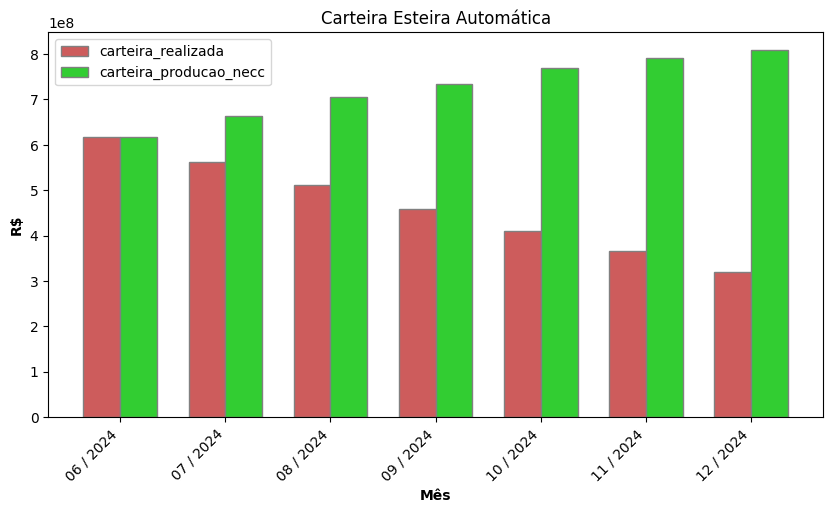

In [ ]:
#@title Projeção Esteira Automática, Paso II: Cálculo da produção necessária para meta
# ---------------- Explicação I ------------------
print('Também usando a mesma metodologia da esteira especializada...')
print('')

# Calcular medias baseadas somente nos tickets desembolsados no mês passado
juros_medio = df_aut.loc[df_aut['data_desembolso'] > (dia_referencia - timedelta(days=31))]['juros_diaria'].mean()
prazo_medio = int(df_aut.loc[df_aut['data_desembolso'] > (dia_referencia - timedelta(days=31))]['dias_ate_vencimento'].mean())

prct_pmt_medio = f_pmt_pc(juros_medio, prazo_medio)

# Limitar a df da projecao com meta até só a última meta
df_aut_proj_meta = df_aut_proj_final.loc[df_aut_proj['data_referencia'] <= (meta_list[-1].dia_meta)]

# Iniciar alguns valores
df_aut_proj_meta["desembolso_necc"] = 0
df_aut_proj_meta['pagamento_diario_producao_necc'] = 0
df_aut_proj_meta['juros_diario_producao_necc'] = 0
df_aut_proj_meta['amort_liqui_producao_necc'] = 0
df_aut_proj_meta['carteira_producao_necc'] = 0

pagamento_meta_cum = np.zeros(len(df_aut_proj_meta))
juros_meta_cum = np.zeros(len(df_aut_proj_meta))
carteira_meta_cum = df_aut_proj_meta['carteira_realizada'].copy()

# ------------------------ Funcao Meta ---------------------------------
dia = 0
# List para guardar producao diaria necessaria para bater a meta
producao_list_es = []

print('Simulando produções...')

for meta in meta_list:
    gap = meta.meta_aut - carteira_meta_cum.loc[meta.dias_ate_meta - 1]
    # Funcao de simulacao para achar producao diaria
    def f_simulacao(meta_diaria):
      carteira_meta_cum_teste = np.zeros(len(df_aut_proj_meta))
      pagamento_meta_cum_teste = np.zeros(len(df_aut_proj_meta))
      dia_teste = dia
      while dia_teste <= meta.dias_ate_meta - 1:
        pagamento = f_pmt(meta_diaria, juros_medio, prazo_medio)
        if df_aut_proj_meta.loc[dia_teste, 'dia_da_semana'] <= 5:
          mask = (df_aut_proj_meta.index >= dia) & (df_aut_proj_meta.index <= prazo_medio)
          # A segunda mask existe para dislocar a coluna de pagamento e juros um dia para baixo.
          mask_pmt = (df_aut_proj_meta.index >= dia + 1) & (df_aut_proj_meta.index <= prazo_medio + 1)
          indices = df_aut_proj_meta.index[mask] - dia_teste
          indices_pmt = df_aut_proj_meta.index[mask_pmt] - dia

          pagamento_meta_cum_teste[mask_pmt] += pagamento
          carteira_realizada_calc = meta_diaria * (1 + juros_medio)**indices - (pagamento / juros_medio) * ((1 + juros_medio)**indices - 1)
          carteira_meta_cum_teste[mask] += carteira_realizada_calc
          dia_teste += 1
        else:
          dia_teste += 1

      # Loop para finais de semana e feriados
      pmt_cum = 0
      for index in range(len(df_aut_proj_meta)):
        if df_aut_proj_meta.loc[index, 'dia_da_semana'] > 5:
          pmt_cum += pagamento_meta_cum_teste[index]
          carteira_meta_cum_teste[index] += pmt_cum
          pagamento_meta_cum_teste[index] = 0
        else:
          pagamento_meta_cum_teste[index] += pmt_cum
          pmt_cum = 0

      return carteira_meta_cum_teste[meta.dias_ate_meta - 1]

    # Funcao para ser colocada no solver
    def f_minimize(meta_diaria):
      return abs(f_simulacao(meta_diaria) - gap)

    # Metodo LBFGSB para funcao nao diferenciavel. Caso ja bateu meta, producao = 0
    if gap < 0:
      optimal_meta_diaria = 0
    else:
      chute_inicial = (meta.meta_aut - gap) / (meta.dias_ate_meta * 0.71)
      result = minimize(f_minimize, x0=chute_inicial, method='L-BFGS-B')
      optimal_meta_diaria = result.x[0]

    # Guardar producoes para display depois
    producao_list_es.append([optimal_meta_diaria, meta.dia_meta.date()])

    # Modificar a tabela principal baseada na producao simulada anteriormente (basicamente mesma estrucutra que a simulação anterior)
    while dia <= meta.dias_ate_meta - 1:
        pagamento = f_pmt(optimal_meta_diaria, juros_medio, prazo_medio)
        if df_aut_proj_meta.loc[dia, 'dia_da_semana'] <= 5:
          if dia - 2 >= 0:
            df_es_proj_meta.loc[dia - 2, 'producao_diaria_necc'] = optimal_meta_diaria
          df_aut_proj_meta.loc[dia, 'desembolso_necc'] = optimal_meta_diaria
          mask = (df_aut_proj_meta.index >= dia) & (df_aut_proj_meta.index <= prazo_medio)
          mask_pmt = (df_aut_proj_meta.index >= dia + 1) & (df_aut_proj_meta.index <= prazo_medio + 1)
          indices = df_aut_proj_meta.index[mask] - dia
          indices_pmt = df_aut_proj_meta.index[mask_pmt] - dia

          pagamento_meta_cum[mask_pmt] += pagamento

          juros_calc = juros_medio * (optimal_meta_diaria * (1 + juros_medio)**(indices_pmt - 1) -
                          (pagamento / juros_medio) * ((1 + juros_medio)**(indices_pmt - 1) - 1))
          juros_meta_cum[mask_pmt] += juros_calc

          carteira_realizada_calc = optimal_meta_diaria * (1 + juros_medio)**indices - (pagamento / juros_medio) * ((1 + juros_medio)**indices - 1)
          carteira_meta_cum[mask] += carteira_realizada_calc
          dia += 1
        else:
          dia += 1

    pmt_cum = 0
    for index in range(len(df_aut_proj_meta)):
      if df_aut_proj_meta.loc[index, 'dia_da_semana'] > 5:
        pmt_cum += pagamento_meta_cum[index]
        carteira_meta_cum[index] += pmt_cum
        pagamento_meta_cum[index] = 0
      else:
        pagamento_meta_cum[index] += pmt_cum
        pmt_cum = 0


df_aut_proj_meta['pagamento_diario_producao_necc'] = pagamento_meta_cum
df_aut_proj_meta['juros_diario_producao_necc'] = juros_meta_cum
df_aut_proj_meta['amort_liqui_producao_necc'] = pagamento_meta_cum - juros_meta_cum
df_aut_proj_meta['carteira_producao_necc'] = carteira_meta_cum

df_aut_proj_meta.drop(columns=['pagamento_diario', 'juros_diario'], inplace=True)

# ----------------------- Transformar em meses ---------------""
df_aut_proj_meta_mes = df_aut_proj_meta.copy()
df_aut_proj_meta_mes.set_index('data_referencia', inplace=True)
df_aut_proj_meta_mes = df_aut_proj_meta_mes.resample('M').last()

# ------------------------ Explicação II ----------------------------------
print(df_aut_proj_meta.loc[meta_list[1].dias_ate_meta - 1])
print(df_aut_proj_meta.loc[meta_list[2].dias_ate_meta - 1])

print('')
print('Usando métodos de otimização, descobrimos que:')
for producao in producao_list_es:
  print(f'A produção diária necessária para bater a meta de {producao[1]} é {producao[0]:,.2f}')

print('')
print('A tabela simulada:')
display(df_aut_proj_meta.head(len(df_aut_proj_meta)))

grafico_barra2(1, df_aut_proj_meta_mes, 'Carteira Esteira Automática', 'carteira_realizada', 'carteira_producao_necc', 'indianred', 'limegreen', dia_final.date(), 10, 5)

Para esteira automática, é possível estimar a produção futura, já que a esteira tem uma natureza muito mais estável do que a especializada.
Podemos fazer essa estimativa baseada na quantidade de ofertas atuais, tamanho médio de tickets, taxa de conversão de clientes, e juros e prazo médio de tickets.
Atualmente temos 83570 ofertas. Consideramos uma taxa de conversão mensal de 1.58%, um ticket médio de R$ 32734.47
Também aplicamos um juros diário médio e prazo médio (baseados nos contratos nos últimos 30 dias) de 0.10% e 750 dias , respectivamente. Temos:


,data_referencia,dia_da_semana,carteira_realizada,producao_diaria_necc,carteira_producao_necc,conversao_diaria_esperada,desembolso_diaria_esperada,amort_liqui_producao_esperada,carteira_producao_esperada,gap_necc-esperada
0,2024-06-28,5,"614,202,260.04",0.00,"614,202,260.04","618,974.98","689,751.52",0.00,"614,892,011.56","-689,751.52"
1,2024-06-29,6,"615,789,471.23",0.00,"615,789,471.23",0.00,0.00,-662.96,"616,479,885.72","-690,414.49"
2,2024-06-30,7,"617,265,672.09",0.00,"617,265,672.09",0.00,0.00,-662.36,"617,956,748.94","-691,076.85"
3,2024-07-01,1,"610,893,195.34","4,526,972.56","615,420,167.90",0.00,"652,448.97","3,211.42","612,233,509.74","3,186,658.16"
4,2024-07-02,2,"609,167,804.57","4,526,972.56","618,214,398.23","8,364,461.01","618,974.98","1,224.03","611,125,869.91","7,088,528.32"
5,2024-07-03,3,"611,116,707.25","4,526,972.56","624,675,562.06","4,892,896.03",0.00,"1,788.86","613,072,983.73","11,602,578.33"
6,2024-07-04,4,"609,581,709.42","4,526,972.56","627,645,456.88","3,471,564.98","8,364,461.01","1,790.58","619,900,656.34","7,744,800.53"
7,2024-07-05,5,"607,844,755.15","4,526,972.56","630,406,018.21","2,692,755.00","4,892,896.03","9,409.06","623,047,189.05","7,358,829.17"
8,2024-07-06,6,"608,440,587.02",0.00,"631,028,006.03",0.00,0.00,"-14,612.04","623,657,632.96","7,370,373.07"
9,2024-07-07,7,"609,034,539.95",0.00,"631,648,072.19",0.00,0.00,"-14,598.71","624,266,184.59","7,381,887.59"


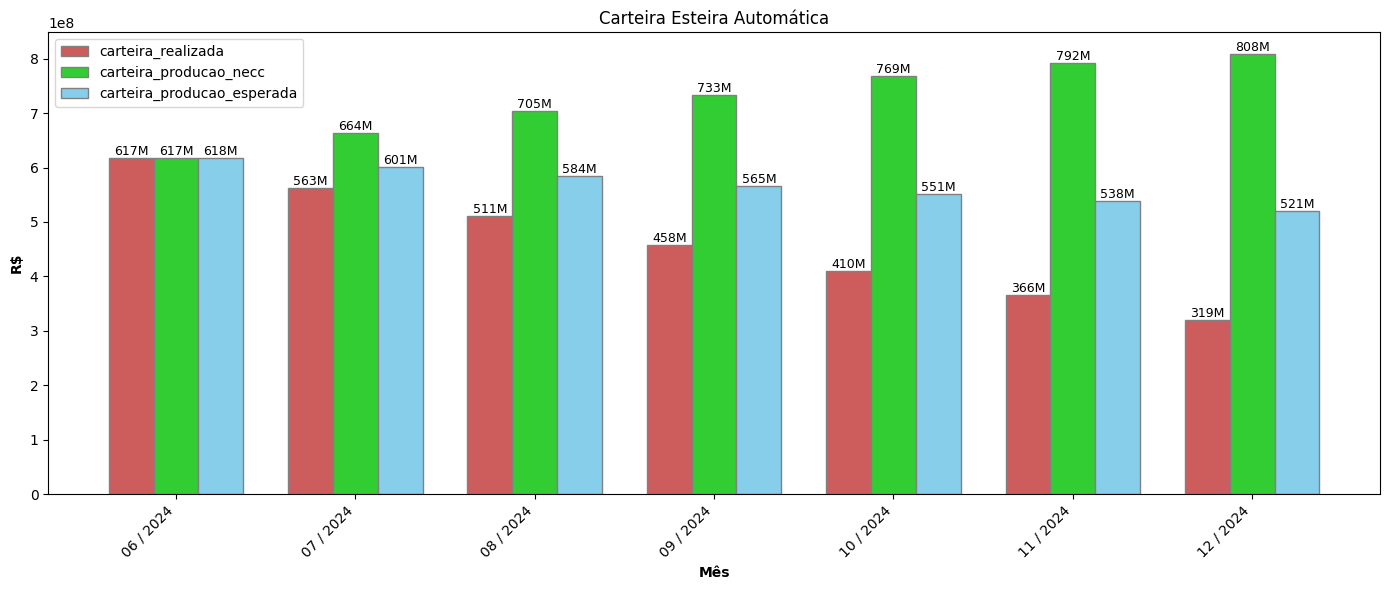

In [ ]:
#@title Projeção Esteira Automática, Paso III: Cálculo da produção esperada
print('Para esteira automática, é possível estimar a produção futura, já que a esteira tem uma natureza muito mais estável do que a especializada.')
print('Podemos fazer essa estimativa baseada na quantidade de ofertas atuais, tamanho médio de tickets, taxa de conversão de clientes, e juros e prazo médio de tickets.')

# Definindo alguns constantes e a tabela onde a simulação vai ocorrer. **importante notar que a projecao vai somente ate o dia da ultima meta
df_aut_proj_esperada = df_aut_proj_meta.copy()

df_aut_proj_esperada['conversao_diaria_esperada'] = 0
df_aut_proj_esperada["desembolso_diaria_esperada"] = 0
df_aut_proj_esperada['pagamento_diario_producao_esperada'] = 0
df_aut_proj_esperada['juros_diario_producao_esperada'] = 0
df_aut_proj_esperada['amort_liqui_producao_esperada'] = 0
df_aut_proj_esperada['carteira_producao_esperada'] = 0

pagamento_producao_cum = np.zeros(len(df_aut_proj_meta))
juros_producao_cum = np.zeros(len(df_aut_proj_meta))
carteira_producao_cum = df_aut_proj_esperada['carteira_realizada'].copy()

# Publicos
class Publico():
  def __init__(self, inicio, final, prazo_medio, juros_medio, ticket_medio, conversao_mensal, ofertas, taxa_negacao):
    self.inicio = inicio
    self.final = final
    self.meta = meta
    self.prazo_medio = prazo_medio
    self.juros_medio = juros_medio
    self.ticket_medio = ticket_medio
    self.conversao_mensal = conversao_mensal
    self.ofertas = ofertas
    self.taxa_negacao = taxa_negacao

# Calculando tamanho do ticket medio da esteira automatica
ticket_medio_aut = df_aut.loc[df_aut['data_desembolso'] > (dia_referencia - timedelta(days=31))]['saldo_gerencial_60'].mean()

publico_default = Publico(dia_referencia, meta_list[-1].dia_meta, prazo_medio, juros_medio, ticket_medio_aut, 0.0158, ofertas_totais, 0.15)
lista_publico = [publico_default]

# Funcao extra para calcular n de dias uteis em um mes
def business_days_in_month(year, month):
    date = datetime(year, month, 1)
    days = 0
    while date.month == month:
        if date.weekday() < 5 and date.date() not in feriados:
            days += 1
        date += timedelta(days=1)
    return days

# funcao para facilitar a estimativa da producao, baseada no dia e no publico fonte
# Count inicial: -n = delay de n dias no desembolso x conversao
def ganho(date, publico, count_inicial):
    if date.weekday() > 4 or date.date() in feriados:
      return 0
    else:
      current_day = date.replace(day=1)
      # Considerando um delay de desembolso de 2 dias
      count = count_inicial
      # esse loop conta qual dia util é o objeto date
      while current_day < date:
          if current_day.weekday() < 5 and current_day.date() not in feriados:
              count += 1
          current_day += timedelta(days=1)
      # Caso count negativo: vai para mes anterior
      if count < 0:
        count = count % business_days_in_month(date.year, date.month - 1)
      # Se fosse negativo, volta a contagem para mes anterior
      return taxa_periodo(count, publico.conversao_mensal) * publico.ofertas * publico.ticket_medio * (1 - publico.taxa_negacao)


for publico in lista_publico:
  dia_int = (publico.inicio - dia_referencia).days
  dia_date = publico.inicio + timedelta(days=1)
  while dia_date <= publico.final - timedelta(days=1):
    conversao_dia = ganho(dia_date, publico, 0)
    desembolso_dia = ganho(dia_date, publico, -2)
    pagamento = f_pmt(desembolso_dia, publico.juros_medio, publico.prazo_medio)

    mask = (df_aut_proj_esperada.index >= dia_int) & (df_aut_proj_esperada.index <= publico.prazo_medio)
    mask_pmt = (df_aut_proj_esperada.index >= dia_int + 1) & (df_aut_proj_esperada.index <= publico.prazo_medio + 1)

    indices = df_aut_proj_esperada.index[mask] - dia_int
    indices_pmt = df_aut_proj_esperada.index[mask_pmt] - dia_int

    pagamento_producao_cum[mask_pmt] += pagamento

    df_aut_proj_esperada.loc[dia_int, 'conversao_diaria_esperada'] = conversao_dia
    df_aut_proj_esperada.loc[dia_int, 'desembolso_diaria_esperada'] = desembolso_dia

    juros_calc = publico.juros_medio * (desembolso_dia * (1 + publico.juros_medio)**(indices_pmt - 1) -
                    (pagamento / publico.juros_medio) * ((1 + publico.juros_medio)**(indices_pmt - 1) - 1))
    juros_producao_cum[mask_pmt] += juros_calc

    carteira_producao_calc = desembolso_dia * (1 + publico.juros_medio)**indices - (pagamento / publico.juros_medio) * ((1 + publico.juros_medio)**indices - 1)
    carteira_producao_cum[mask] += carteira_producao_calc

    dia_int += 1
    dia_date += timedelta(days=1)

    pmt_cum = 0
    producao_cum = 0

  # Mecanismos de finais de semana
  for index in range(len(df_aut_proj_esperada)):
    if df_aut_proj_esperada.loc[index, 'dia_da_semana'] > 5:
      pmt_cum += pagamento_producao_cum[index]
      carteira_producao_cum[index] += pmt_cum
      pagamento_producao_cum[index] = 0
    else:
      pagamento_producao_cum[index] += pmt_cum

      pmt_cum = 0
      producao_cum = 0


df_aut_proj_esperada['pagamento_diario_producao_esperada'] = pagamento_producao_cum
df_aut_proj_esperada['juros_diario_producao_esperada'] = juros_producao_cum
df_aut_proj_esperada['amort_liqui_producao_esperada'] = pagamento_producao_cum - juros_producao_cum
df_aut_proj_esperada['carteira_producao_esperada'] = carteira_producao_cum
df_aut_proj_esperada['gap_necc-esperada'] = df_aut_proj_esperada['carteira_producao_necc'] - df_aut_proj_esperada['carteira_producao_esperada']

# ----------------------- Transformar em meses ---------------""
df_aut_proj_esperada_mes = df_aut_proj_esperada.copy()
df_aut_proj_esperada_mes.set_index('data_referencia', inplace=True)
df_aut_proj_esperada_mes = df_aut_proj_esperada_mes.resample('M').last()

# ---------------------- Explicação ---------------------------
df_aut_proj_esperada.drop(columns=['pagamento_diario_producao_necc', 'amort_liqui_producao_necc',
                                   'juros_diario_producao_necc', 'amort_liqui',
                                   'pagamento_diario_producao_esperada', 'juros_diario_producao_esperada'
                                   ], inplace=True)

print(f'Atualmente temos {publico_default.ofertas} ofertas. '
f'Consideramos uma taxa de conversão mensal de {publico_default.conversao_mensal * 100}%, um ticket médio de R$ {publico_default.ticket_medio:.2f}')
print(f'Também aplicamos um juros diário médio e prazo médio (baseados nos contratos nos últimos 30 dias) de {publico_default.juros_medio * 100:.2f}% e {publico_default.prazo_medio} dias , respectivamente. Temos:')

display(df_aut_proj_esperada.head(20))
grafico_barra3(1, df_aut_proj_esperada_mes, 'Carteira Esteira Automática', 'carteira_realizada', 'carteira_producao_necc', 'carteira_producao_esperada',
               'indianred', 'limegreen', 'skyblue', dia_final.date(), 14, 6)

LEFT JOIN
  `dataplatform-prd.credit_business_intelligence.tbl_business_offer_tracker` b
    ON a.LoanId = b.LoanId